# 定義欄

In [78]:
import xml.etree.ElementTree as ET 
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from PIL import Image
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path


#マスタデータのインポート
master = pd.read_csv(os.getcwd() + "/Resources/RugbyHub_master_data.csv",dtype=str)

#PLID,TEAMIDのインポート
psheets = ["PLID", "TID", "Venue"]
plid = pd.read_csv(os.getcwd()+"/Resources/plid_master.csv",dtype=str)
ptid = pd.read_excel(os.getcwd() +"/Resources/Japan Rugby League One Player ID.xlsx", sheet_name = psheets,dtype=str)
tid = pd.DataFrame(ptid["TID"])
venue = pd.DataFrame(ptid["Venue"])

def read_xml(FILEPATH):
    # XMLファイルを解析
    tree = ET.parse(FILEPATH) 

    # XMLを取得
    root = tree.getroot()
    df = pd.DataFrame(index=[],columns = ['ID','FXID','PLID','team_id','ps_timestamp','ps_endstamp','MatchTime','psID','period',
               'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum',
               'sequence_id','player_advantage','score_advantage','flag','advantage','assoc_player'])

    row_num = 0
    for action in root.iter('ActionRow'):
        s = pd.Series([action.get('ID'),action.get('FXID'),action.get('PLID'),action.get('team_id'),
                       action.get('ps_timestamp'),action.get('ps_endstamp'),action.get('MatchTime'),action.get('psID'),
                       action.get('period'),action.get('x_coord'),action.get('y_coord'),action.get('x_coord_end'),action.get('y_coord_end'),
                       action.get('action'),action.get('ActionType'),action.get('Actionresult'),action.get('qualifier3'),
                       action.get('qualifier4'),action.get('qualifier5'),action.get('Metres'),action.get('PlayNum'),action.get('SetNum'),
                       action.get('sequence_id'),action.get('player_advantage'),action.get('score_advantage'),action.get('flag'),
                       action.get('advantage'),action.get('assoc_player')],index=df.columns)

        df.loc[row_num, :] = s
        row_num = row_num+1
    
    df[['PlayNum','SetNum','sequence_id','MatchTime','x_coord', 'y_coord','x_coord_end', 'y_coord_end']] = df[['PlayNum', 'SetNum','sequence_id','MatchTime','x_coord', 'y_coord','x_coord_end', 'y_coord_end']].astype(int)
    df[['ps_timestamp','ps_endstamp']] = df[['ps_timestamp','ps_endstamp']].astype(float)
    
    df.qualifier3 = df.qualifier3.map(master.set_index('ID').Definition)
    df.qualifier4 = df.qualifier4.map(master.set_index('ID').Definition)
    df.qualifier5 = df.qualifier5.map(master.set_index('ID').Definition)
    df.Actionresult = df.Actionresult.map(master.set_index('ID').Definition)
    df.ActionType = df.ActionType.map(master.set_index('ID').Definition)
    df.action = df.action.map(master.set_index('ID').Definition)
    df.team_id = df.team_id.map(plid.set_index('players_id').team_name)
    df.PLID = df.PLID.map(plid.set_index('players_id').player_known_name)
    
#     下の処理を入れるとruck_speedメソッドが動作しなくなるので注意
    df = pd.merge(df, get_player_list(FILEPATH), left_on='PLID', right_on='Player_name').drop(columns='Player_name')
#     df.to_csv('/Users/isakakou/Desktop/advanced_superscout.csv', header=True, index=False)
    return df

def read_all(directory):
    # ファイルの中身を追加していくリストを用意
    df = pd.DataFrame()
    #読み込むファイルのリストを走査
    for file in directory:
        print(file)
        data = read_xml(file)
#         走査する過程でメソッドを実行できる
        df = pd.concat([df,data],axis=0)
    #リストを全て行方向に結合
    #axis=0:行方向に結合, sort
    
    # df.to_csv("/Users/isakakou/Desktop/22-23_Stats/total.csv",index=False)
    return df

def get_player_list(FILEPATH):
    # XMLファイルを解析
    tree = ET.parse(FILEPATH)
    # XMLを取得
    root = tree.getroot()
    df = pd.DataFrame(index=[],columns = ['ShirtNo','Club','PosID','Player_name','team_name','MINS'])
    row_num = 0
    for pl in root.iter('Player'):
        s = pd.Series([int(pl.get('ShirtNo')),pl.get('Club'),pl.get('PosID'),pl.get('PLFORN')+' '+ pl.get('PLSURN'),pl.get('TEAMNAME'),pl.get('MINS')],index = df.columns)
        df.loc[row_num, :] = s
        row_num = row_num+1
    return df

def ruck_speed(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] == 'Ruck']
    rspeed = ['0-1 Seconds','1-2 Seconds','2-3 Seconds','3-4 Seconds','4-5 Seconds','5-6 Seconds','6+ Seconds', 'N/A Ruck Speed']
    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 68)
    plt.ylim(0,100)
    
    a = pd.crosstab(dfaction['action'],dfaction['qualifier4'])
    a = a.reindex(columns=rspeed).fillna(0).astype(int)
#     a.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Ruck Speed.csv')

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    for i in range(len(rspeed)):
        r = dfaction.loc[dfaction['qualifier4'] == rspeed[i]]
        plt.scatter(r['y_coord'], r["x_coord"], label=rspeed[i] ,marker = 'D',color=cl[i], s=150)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    OPPONENT = get_opponent(df,TEAMNAME)
    plt.title(TEAMNAME +" Ruck (" + TEAMNAME + " vs " + OPPONENT + ")")
    plt.gcf().subplots_adjust(wspace=4)
    plt.savefig('/Users/isakakou/Desktop/Rucks/' + TEAMNAME +" Ruck (" + TEAMNAME + " vs " + OPPONENT + ")" + '.png',bbox_inches='tight')
    plt.show()
    
def calculate_gainline_crossed_rate(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Carry']
    carries = dfaction['qualifier3'].value_counts().to_dict()
    carries['total'] = sum(carries.values())
    print(f"crossed:{round(carries['Crossed Gain line']/carries['total']*100,2)}%, neutral:{round(carries['Neutral Gain line']/carries['total']*100,2)}%, failed:{round(carries['Failed Gain line']/carries['total']*100,2)}%")

def carry_meter(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    players = dfaction.drop_duplicates(subset=['PLID'],keep='first')
    player_list = players['PLID']
    player_list = player_list.reset_index(drop=True)
    carry_meter = pd.DataFrame()

    for i in range(len(player_list)):
        player_dfaction = dfaction.loc[dfaction['PLID'] == player_list[i]]
        carry = player_dfaction.loc[player_dfaction['action'] == 'Carry']
        carry_list = carry['Metres'].astype(int)
        s = pd.Series([player_list[i],carry_list.sum()], index = ['Name','Metres'])
        carry_meter = carry_meter.append(s, ignore_index=True)

    #carry_meter.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Carry_Meter.csv')
    
    
def lineout(df,TEAMNAME):
    #チーム名指定でラインアウトデータ取得
    df = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = df.loc[df['action'] == 'Lineout Throw']
    b = pd.crosstab([dfaction['qualifier3'],dfaction['Actionresult']],dfaction['ActionType'],margins=True)
    b = b.reindex(columns=['Throw Front', 'Throw Middle', 'Throw Back', 'Throw 15m+'])

    plt.gcf().subplots_adjust(wspace=4)
    sns.heatmap(b,cmap='Blues', annot=True,annot_kws={'size':20})
    plt.show()
    plt.clf()
    
def kick(df, TEAMNAME):
    #Kickが入力された場合の処理-----
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Kick']
    kicktypes = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick','Kick Error']
    kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]

    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 70)
    plt.ylim(0,100)

    print(kicks[['PLID','MatchTime','ActionType','Actionresult']])
    for i in range(len(kicktypes)):
        plts = kicks.loc[kicks['ActionType']== kicktypes[i]]
        plt.quiver(plts['y_coord'], plts["x_coord"], (plts['y_coord_end']-plts['y_coord']), (plts["x_coord_end"]-plts['x_coord']), angles="xy", scale_units='xy',label= kicktypes[i], color = cl[i], scale=1,width=0.008, headwidth=5, headlength = 8, headaxislength = 7, pivot='tail')
    #Kickの処理ここまで------

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.title(TEAMNAME)
    plt.gcf().subplots_adjust(wspace=4)
    plt.show()

    #表を出力
    player_kicks = pd.crosstab([kicks['PLID'],kicks['ActionType']],kicks['Actionresult'])
    player_kicks.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Kick Details.csv')
    display(player_kicks)
    
def twenty_two_entry(df,TEAMNAME):
    twenty_two_entry_outcome = ['22 Entry Outcome - Turnover','22 Entry Outcome - Try','22 Entry Outcome - Scrum Won','22 Entry Outcome - Penalty Won'
    ,'22 Entry Outcome - Penalty Goal Attempt','22 Entry Outcome - Penalty Conceded','22 Entry Outcome - Lineout Won','22 Entry Outcome - Kick Turnover'
    ,'22 Entry Outcome - Drop Goal']
    twenty_two_entry_points =['22 Entry Points - Try without Conversion','22 Entry Points - Try and Conversion'
    ,'22 Entry Points - Penalty Try','22 Entry Points - Penalty Goal','22 Entry Points - Drop Goal']
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'].str.contains('22 Entry',na=False)]
    display(dfaction[['action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','PlayNum','SetNum']])

def possession_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action']=='Possession']
    start_from_opp_22 = dfaction.loc[dfaction['x_coord'] >=77]
    display(start_from_opp_22[['team_id','action','ActionType','Actionresult','MatchTime','score_advantage']])
    
def tackle_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Tackle']
    tackle_table = pd.crosstab([dfaction['ActionType'],dfaction['Actionresult']],dfaction['qualifier3'])
    display(tackle_table)
    
def tackle_player_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Tackle']
    tackle__quality_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['qualifier3'],dfaction['Actionresult']]).sort_values('ShirtNo')
    tackle_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3']).sort_values('ShirtNo')
    tackle__quality_table.to_excel('/Users/isakakou/Desktop/'+TEAMNAME +' Tackle.xlsx')
    display(tackle__quality_table)
    display(tackle_table)
    
def pass_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Pass']
    pass_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['ActionType'],dfaction['Actionresult']]).sort_values('ShirtNo')
    display(pass_table)
    
def maul_table(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] == 'Maul']
    display(dfaction)
    maul_table = pd.crosstab(dfaction['Actionresult'],dfaction['qualifier5'])
    display(maul_table)
    
def attack_OOA(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['qualifier4'] =='Attacking OOA']
    display(dfaction[['PLID', 'ActionType','Actionresult','qualifier3','qualifier4','qualifier5']])
    attack_OOA_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['Actionresult'],dfaction['ActionType']]).sort_values('ShirtNo')
    display(attack_OOA_table)
    attack_OOA_table.to_excel('/Users/isakakou/Desktop/'+TEAMNAME +' Attacking Ruck OOA.xlsx')
#     plt.gcf().subplots_adjust(wspace=4)
#     sns.heatmap(attack_OOA_table,cmap='Blues', annot=True,annot_kws={'size':20})
#     plt.rcParams["figure.figsize"] = (10,30)
#     plt.show()

def try_detail(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    try_set = dfaction.loc[dfaction['action'] == 'Try']
    try_set_list = try_set['SetNum']
    try_set_list = try_set_list.reset_index(drop=True)
    try_datas = pd.DataFrame()
    for i in range(len(try_set_list)):
        try_data = dfaction.loc[dfaction['SetNum'] == try_set_list[i]]
        try_datas = try_datas.append(try_data, ignore_index=True)
    display(try_datas[['PLID', 'action','ActionType','Actionresult','qualifier3','qualifier4','qualifier5','PlayNum','MatchTime']])
    
def get_opponent(df, TEAMNAME):
    opp = df.loc[df['team_id'] != TEAMNAME].reset_index(drop=True).team_id[0]
    return opp


# TODO 起点によって実際のPossessionと定義上のPossessionでチームが異なる問題に対処する
def plot_rucks_per_possession(df, TEAMNAME):
    start_of_possessions = ['Restart Return', '50m Restart Retained','22m Restart','22m Restart Retained',
                            'Free Kick', 'Kick Return', 'Turnover Won','Lineout', 'Lineout Steal', 'Scrum',
                            'Scrum Steal', 'Tap Pen', 'Goal Line Restart', 'Goal Line Restart Retained']
    cmap = plt.get_cmap("jet")
    for i in range(len(start_of_possessions)):
        l=1
        fig = plt.figure(figsize=(7, 10))
        ax = fig.add_subplot(1, 1,1)
        plt.xlim(0, 68)
        plt.ylim(0,100)
        #背景画像の設定
        fig.patch.set_facecolor('white')
        im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)
#         TODO 50m, 22m, Goal LineでのRestartを区別する(直前のRestart KickのActionTypeを取得する)
        if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
            plts = df.loc[((df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME)]
        else:
            plts = df.loc[(((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME))]
#         else:
#         plts = df.loc[(df['action'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)].reset_index()
        plt.scatter(plts['y_coord'], plts["x_coord"] ,marker = 'D',s=150, color='red',zorder=2)
        for sn in plts.SetNum:
            if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
                start_of_set = df.loc[(df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)&(df['SetNum'] == sn)]
            else:
                start_of_set = df.loc[((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['SetNum'] == sn)]
            sets = df.loc[(df['SetNum'] == sn) & (df['action'] == 'Ruck')&(df['team_id'] == TEAMNAME)]
            sets = pd.concat([start_of_set,sets])
            x = sets['y_coord']
            y = sets["x_coord"]
            plt.plot(x, y,lw = 2,marker = 'o',color = cmap(l), markersize = 10,zorder=1)
            l=l+14
        # グラフタイトル
        plt.title('Rucks of ' + TEAMNAME +' (Start:'+ start_of_possessions[i] + ')', fontsize=18)
        # 散布図表示
        plt.gcf().subplots_adjust(wspace=4)
        plt.show()
        plt.clf()
        
def tackle_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id']==TEAMNAME) &(df['action']=='Tackle')]
    tackle = pd.crosstab([dfaction['PLID'],dfaction['ActionType']],dfaction['Actionresult'])
    tackle_result = pd.crosstab(dfaction['PLID'],dfaction['Actionresult'])
    tackle_result_discriptor = dfaction['Actionresult'].drop_duplicates()
    fig = plt.figure(dpi=200,figsize=(16, 12),facecolor='white')
    ax = fig.add_subplot(111)
    tackle_bar_graph = tackle_result.plot.barh(width=0.9,stacked=True,ax=ax)
    #labelsizeで軸の数字の文字サイズ変更
    plt.tick_params(labelsize=15)
    #fontsizeで凡例の文字サイズ変更
    plt.legend(fontsize=15)
    plt.legend(tackle_result_discriptor, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
def defensive_penalty(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] =='Penalty']
    defensive_penalty_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3'])
    display(defensive_penalty_table)
    
def turnover(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] =='Turnover']
    turnover_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3'])
    display(turnover_table)
    
def count_ball_movement(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    ball_movement_list = ['Close Left Open Movement', 'Close Right Open Movement','Close Left Blindside Movement','Close Right Blindside Movement','Tight Left Open Movement','Tight Right Open Movement','Tight Left Blindside Movement','Tight Right Blindside Movement','Mid Left Open Movement','Mid Right Open Movement','Wide Left Open Movement','Wide Right Open Movement']
    dfaction = dfaction.loc[(dfaction['qualifier5'] != 'None')&(dfaction['action'] == 'Ruck')]
    ball_movements = dfaction['qualifier5'].value_counts().to_dict()
    for bm in ball_movement_list:
        if bm not in ball_movements.keys():
            ball_movements[bm] = 0
    print(ball_movements)
    ball_movements['tight'] = ball_movements['Tight Left Open Movement'] + ball_movements['Tight Right Open Movement'] + ball_movements['Tight Left Blindside Movement'] + ball_movements['Tight Right Blindside Movement']
    ball_movements['close'] = ball_movements['Close Left Open Movement'] + ball_movements['Close Right Open Movement'] + ball_movements['Close Left Blindside Movement'] + ball_movements['Close Right Blindside Movement']
    ball_movements['mid'] = ball_movements['Mid Left Open Movement'] + ball_movements['Mid Right Open Movement']
    ball_movements['wide'] = ball_movements['Wide Left Open Movement'] + ball_movements['Wide Right Open Movement']
    ball_movements['total'] = ball_movements['tight'] + ball_movements['close'] +  ball_movements['mid'] +  ball_movements['wide']
    print(f"tight:{ball_movements['tight']}, close:{ball_movements['close']}, mid:{ball_movements['mid']}, wide{ball_movements['wide']}")
    print(f"tight:{round(ball_movements['tight']/ball_movements['total']*100,2)}%, close:{round(ball_movements['close']/ball_movements['total']*100,2)}%, mid:{round(ball_movements['mid']/ball_movements['total']*100,2)}%, wide{round(ball_movements['wide']/ball_movements['total']*100,2)}%")
    
def count_average_phases(df, team_list):
    team_phase_list = {}
    for team in team_list:
        dfaction = df.loc[df['team_id'] == team]
        phase_list = []
        set_number_list = dfaction.SetNum.drop_duplicates(keep='first')
        for sn in set_number_list:
            _set = dfaction.loc[dfaction['SetNum']==sn]
            phase_list.append(_set.PlayNum.max())
        print(f"Team: {team}, Average: {np.mean(phase_list)}")
        team_phase_list[team] = phase_list
    return team_phase_list

def average_phase_kick_corr(df, team_list):
    team_phase_list = count_average_phases(df, team_list)
    phase_kick_df = pd.DataFrame(index=[],columns=["team_name", "average_phase", "total_kicks"])
    row_num=0
    for team in team_phase_list.keys():
        dfaction = df.loc[(df['team_id'] == team)]
        dfaction = dfaction.loc[dfaction['action'] == 'Kick']
        kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]
        s = pd.Series([team,np.mean(team_phase_list[team]),kicks.action.count()], index = ['team_name','average_phase','total_kicks'])
        phase_kick_df.loc[row_num, :] = s
        row_num = row_num+1
    sns.scatterplot(x='average_phase', y='total_kicks', hue='team_name', data=phase_kick_df,palette='tab10')
    # plt.scatter(phase_kick_df['average_phase'],phase_kick_df['total_kicks'],label = phase_kick_df['team_name'])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.show()
    

# 全試合から対象チームのキックを抽出してプロット
def kicks_from_all_game(directory, TEAMNAME):
    df = read_all(directory)
    # Kickが入力された場合の処理-----
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = dfaction.loc[dfaction['action'] == 'Kick']
    kicktypes = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick','Kick Error']
    kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]

    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    players = kicks.drop_duplicates(subset=['PLID'],keep='first')
    player_list = players['PLID'].reset_index(drop=True)
    print(player_list)

    for p in range(len(player_list)):
        fig = plt.figure(figsize=(7, 10))
        ax = fig.add_subplot(1, 1,1)
        plt.grid(False)
        plt.xlim(0, 68)
        plt.ylim(0,100)
        for i in range(len(kicktypes)):
            plts = kicks.loc[(kicks['ActionType']== kicktypes[i])&(kicks['PLID'] == player_list[p])]
            plt.quiver(plts['y_coord'], plts["x_coord"], (plts['y_coord_end']-plts['y_coord']), (plts["x_coord_end"]-plts['x_coord']), angles="xy", scale_units='xy',label= kicktypes[i], color = cl[i], scale=1,width=0.008, headwidth=5, headlength = 8, headaxislength = 7, pivot='tail')
        #Kickの処理ここまで------

        #背景画像の設定
        fig.patch.set_facecolor('white')
        im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)
        # ポジション取得の仕方は要検討
        position = dfaction.loc[dfaction['PLID'] == player_list[p]].drop_duplicates(keep='first').reset_index(drop=True)

        # ラベルの表示
        lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
        plt.title(player_list[p] + "\n Position: " + position['PosID'][0])
        plt.gcf().subplots_adjust(wspace=4)
        plt.show()
        
def bar_chart_for_comparison(df,action):
    team_list = df['team_id'].drop_duplicates(keep='first').reset_index(drop=True)
    dfaction = df.groupby('team_id')['action'].value_counts().unstack()
    # 棒グラフを作成
    dfaction.plot(kind='barh', stacked=True)
    plt.xlabel("Count")
    plt.title(action)
    plt.show()
    
        
def summarize_competition(directory):
    df = read_all(directory)
    action_list = df['action'].drop_duplicates(keep='first').reset_index(drop=True)
    pdf =  PdfPages('/Users/isakakou/Desktop/Competition_Stats/competition_summary.pdf')
    for action in action_list:
        plot_action_type_breakdown(df,action,pdf)
        plot_team_breakdown(df,action,pdf)
    pdf.close()
            
def plot_action_type_breakdown(df,action,pdf):
    action_type_list = get_action_type_list(df, action)
    action_type_counts = get_action_type_counts(df, action, action_type_list)
    action_type_counts['sum'] = action_type_counts.sum(axis=1)
    action_type_counts = action_type_counts.sort_values(by ='sum',ascending=True)
    action_type_counts.drop(columns='sum', inplace=True)
    if action == 'Kick':
        cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
        action_type_counts.plot(kind='barh', stacked=True, color=cl)
    else:
        action_type_counts.plot(kind='barh', stacked=True)
    plt.xlabel(f"{action} details per game")
    plt.title(f"{action} details per game")
    plt.legend(bbox_to_anchor=(1.05, 1))
    pdf.savefig(plt.gcf(),bbox_inches='tight')
    plt.show()
    
def plot_team_breakdown(df,action,pdf):
    team_action_counts = get_team_action_counts(df,action)
    team_action_counts = team_action_counts.sort_values(ascending=True)
    team_action_counts.drop(columns='sum', inplace=True)
    fig = plt.figure()
    team_action_counts.plot(kind='barh', stacked=True)
    plt.xlabel(f"{action} per game")
    plt.title(f"{action} per game")
    if 'Green Rockets Tokatsu' in team_action_counts.index:
        ax = plt.gca()
        green_rocket_index = team_action_counts.index.get_loc('Green Rockets Tokatsu')
        ax.barh(green_rocket_index, team_action_counts['Green Rockets Tokatsu'], color='orange')
    pdf.savefig(fig, bbox_inches='tight')
    plt.show()
    
def get_action_type_list(df, action):
    if action == 'Kick':
        action_type_list = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick', 'Kick Error']
    elif action in ['Tackle','Scrum','Offensive Scrum','Defensive Scrum']:
        action_type_list = df.loc[df['action'] == action].Actionresult.drop_duplicates(keep='first').reset_index(drop=True)
    elif action in ['Carry']:
        action_type_list = df.loc[df['action'] == action].qualifier3.drop_duplicates(keep='first').reset_index(drop=True)
    else:
        action_type_list = df.loc[df['action'] == action].ActionType.drop_duplicates(keep='first').reset_index(drop=True)
    return action_type_list   

def get_team_action_counts(df, action):
    if action == 'Kick':
        team_action_counts = df.loc[(df['action'] == action)&(df['qualifier3'] != 'Penalty Kick')].groupby('team_id')['action'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
    else:    
        team_action_counts = df.loc[df['action'] == action].groupby('team_id')['action'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
    return team_action_counts
    
def get_action_type_counts(df, action, action_type_list):
    action_type_counts = pd.DataFrame()
    for action_type in action_type_list:
        if (action in ['Tackle', 'Scrum','Offensive Scrum','Defensive Scrum']):
            counts = df[(df['action'] == action) & (df['Actionresult'] == action_type)].groupby("team_id")['Actionresult'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        elif action == 'Carry':
            counts = df[(df['action'] == action) & (df['qualifier3'] == action_type)].groupby("team_id")['qualifier3'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        elif action == 'Kick':
            counts = df[(df['action'] == action) & (df['ActionType'] == action_type)&(df['qualifier3'] != 'Penalty Kick')].groupby("team_id")['qualifier3'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        else:
            counts = df[(df['action'] == action)&(df['ActionType']== action_type)].groupby("team_id")['ActionType'].count()/df[df['action'] == action].groupby('team_id').FXID.nunique()
        counts.name = action_type
        action_type_counts = pd.concat([action_type_counts, counts], axis=1)
    return action_type_counts

def plot_boundary(model, X, Y, target, xlabel,ylabel):
    cmap_dots = mcolors.ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])
    cmap_fills = mcolors.ListedColormap(['#c6dcec', '#ffdec2', '#cae7ca'])
    
    plt.figure(figsize=(5,5))
    if model:
        XX,YY = np.meshgrid(np.linspace(X.min()-1, X.max()+1, 200),
                           np.linspace(Y.min()-1, Y.max()+1, 200))
        
        pred = model.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        plt.pcolormesh(XX, YY, pred, cmap=cmap_fills,shading='auto')
        plt.contour(XX,YY,pred,colors='gray')
    plt.scatter(X,Y,c=target,cmap=cmap_dots)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

/Users/isakakou/Desktop/22-23_super_scout/933721_SUNTvDYNA_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933691_SUNTvKUBO_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933723_SHBRvNECG_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933710_SHBRvRICH_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933689_TVERvSHBR_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933732_TVERvNECG_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933753_DYNAvCANO_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933751_SHBRvKUBO_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933722_KUBOvRICH_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933743_TOSHvKOBE_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933703_TVERvRICH_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933718_SAWKvCANO_advanced_superscout.xml
/Use

,ID,FXID,PLID,team_id,ps_timestamp,ps_endstamp,MatchTime,psID,period,x_coord,...,player_advantage,score_advantage,flag,advantage,assoc_player,ShirtNo,Club,PosID,team_name,MINS
0,1,933721,Jamie Shillcock,Mitsubishi Sagamihara Dynaboars,0.00,0.00,1,0,1,50,...,0,0,False,0,0,10,594,10,Mitsubishi Sagamihara Dynaboars,80
1,36,933721,Jamie Shillcock,Mitsubishi Sagamihara Dynaboars,26.12,26.12,27,0,1,54,...,0,0,False,0,0,10,594,10,Mitsubishi Sagamihara Dynaboars,80
2,54,933721,Jamie Shillcock,Mitsubishi Sagamihara Dynaboars,35.40,35.40,37,0,1,53,...,0,0,False,0,0,10,594,10,Mitsubishi Sagamihara Dynaboars,80
3,55,933721,Jamie Shillcock,Mitsubishi Sagamihara Dynaboars,35.44,35.44,37,0,1,55,...,0,0,False,0,0,10,594,10,Mitsubishi Sagamihara Dynaboars,80
4,56,933721,Jamie Shillcock,Mitsubishi Sagamihara Dynaboars,35.44,35.44,37,0,1,55,...,0,0,False,0,0,10,594,10,Mitsubishi Sagamihara Dynaboars,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,2765,933699,Hideto Niguma,Tokyo Sungoliath,5719.04,5719.04,7035,0,2,92,...,-1,19,False,0,0,23,5209,15,Tokyo Sungoliath,10
2667,2810,933699,Hideto Niguma,Tokyo Sungoliath,5895.32,5895.32,7331,0,2,59,...,-1,26,False,0,0,23,5209,15,Tokyo Sungoliath,10
2668,2811,933699,Hideto Niguma,Tokyo Sungoliath,5895.88,5895.88,7332,0,2,64,...,-1,26,False,0,0,23,5209,15,Tokyo Sungoliath,10
2669,2814,933699,Hideto Niguma,Tokyo Sungoliath,5898.32,5898.32,7334,0,2,59,...,-1,26,False,0,0,23,5209,15,Tokyo Sungoliath,10


Team: Green Rockets Tokatsu, Average: 6.3238095238095235
Team: Yokohama Canon Eagles, Average: 5.700934579439252
Team: Toshiba Brave Lupus Tokyo, Average: 6.31858407079646
Team: Shizuoka BlueRevs, Average: 7.027777777777778
Team: Kubota Spears, Average: 6.158878504672897
Team: Hanazono Kintetsu Liners, Average: 6.699029126213592
Team: Saitama Wild Knights, Average: 6.371681415929204
Team: Toyota Verblitz, Average: 6.914285714285715
Team: BlackRams Tokyo, Average: 6.364485981308412
Team: Mitsubishi Sagamihara Dynaboars, Average: 6.330357142857143
Team: Tokyo Sungoliath, Average: 8.097826086956522
Team: Kobelco Kobe Steelers, Average: 6.96


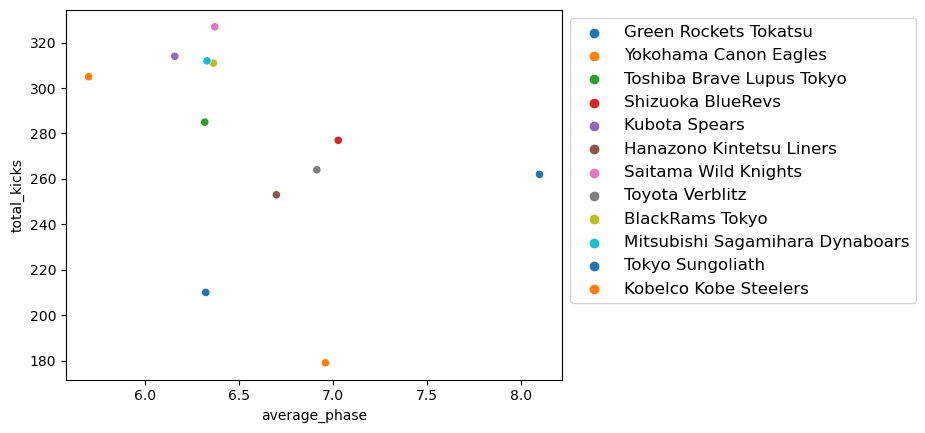

In [80]:
FILEPATH = '/Users/isakakou/Desktop/22-23_super_scout/933713_CANOvNECG_advanced_superscout.xml'
TEAMNAME = 'Green Rockets Tokatsu'
# パスで指定したファイルの一覧をリスト形式で取得.
directory = glob.glob('/Users/isakakou/Desktop/22-23_super_scout/*.xml')

df = read_all(directory)
display(df)
# summarize_competition(directory)
# df = read_xml(FILEPATH)
team_list = ["Green Rockets Tokatsu", "Yokohama Canon Eagles","Toshiba Brave Lupus Tokyo","Shizuoka BlueRevs","Kubota Spears",
            "Hanazono Kintetsu Liners", "Saitama Wild Knights","Toyota Verblitz","BlackRams Tokyo","Mitsubishi Sagamihara Dynaboars",
            "Tokyo Sungoliath","Kobelco Kobe Steelers"]
# count_average_phases(df, team_list)
average_phase_kick_corr(df, team_list)
# sns.lineplot(x="sequence_id", y="score_advantage", data=df)
# pd_df = pd.get_dummies(df[['PLID','team_id','MatchTime','psID','period',
#                'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
#                'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum']])
# df = read_all(directory)
# count_ball_movement(df, TEAMNAME)
# calculate_gainline_crossed_rate(df, TEAMNAME)
# kick(df,TEAMNAME)
# Kubota Spears
# Green Rockets Tokatsu
# ruck_speed(df, TEAMNAME)
# carry_meter(df, TEAMNAME)
# lineout(df,TEAMNAME)
# twenty_two_entry(df,TEAMNAME)
# possession_detail(df, TEAMNAME)
# pass_table(df, TEAMNAME)
# tackle_player_table(df, TEAMNAME)
# tackle_player_table(df, TEAMNAME)
# defensive_penalty(df, TEAMNAME)
# attack_OOA(df,TEAMNAME)
# get_opponent(df, TEAMNAME)
# try_detail(df, get_opponent(df, TEAMNAME))
# plot_rucks_per_possession(df,TEAMNAME)
# tackle_detail(df, TEAMNAME)
# turnover(df,TEAMNAME)
# kicks_from_all_game(directory, TEAMNAME)

# --------------------------------------------------------------------------
#読み込むファイルのリストを走査
# for file in directory:
#     print(file)
#     data = read_xml(file)
#     ruck_speed(data, TEAMNAME)
#     OPPONENT = get_opponent(data,TEAMNAME)
#     plot_rucks_per_possession(data,OPPONENT)

In [ ]:
# df = read_xml('/Users/isakakou/Desktop/22-23_super_scout/933717_DYNAvSHBR_advanced_superscout.xml')
directory = glob.glob('/Users/isakakou/Desktop/22-23_super_scout/*NECG*.xml')
df = read_all(directory)

le = LabelEncoder()
df['Actionresult'] = le.fit_transform(df['Actionresult'])
dummies = pd.get_dummies(df[['action','PLID', 'ActionType','FXID']])
coords = df[['x_coord','y_coord','x_coord_end','y_coord_end']]
X = pd.concat([dummies,coords],axis=1)
# df[['x_coord', 'y_coord']].fillna(0)
y = df['Actionresult']
X_train, X_test, y_train, y_test = train_test_split(X,y)
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
print("正解率:",score*100, "%")
df2 = pd.DataFrame(X_test)

# Define Neural Network model
clf = MLPClassifier(hidden_layer_sizes=20, activation='relu',
                    solver='adam', max_iter=1000)
# Lerning model
clf.fit(X_train, y_train)
print("ニューラルネットワーク正解率:",clf.score(X_train, y_train)*100,'%')
print(clf.predict(X_test))
# print(df2)
# plot_boundary(model, X_test['x_coord'],X_test['y_coord'],y_test,"df2[0]", "df2[1]")